   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 90.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=927df18efdc36b176a0cd883d4c7cf8faab52400bba49d014f16d2e4776c7251
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc
Initial state of qubit 0:


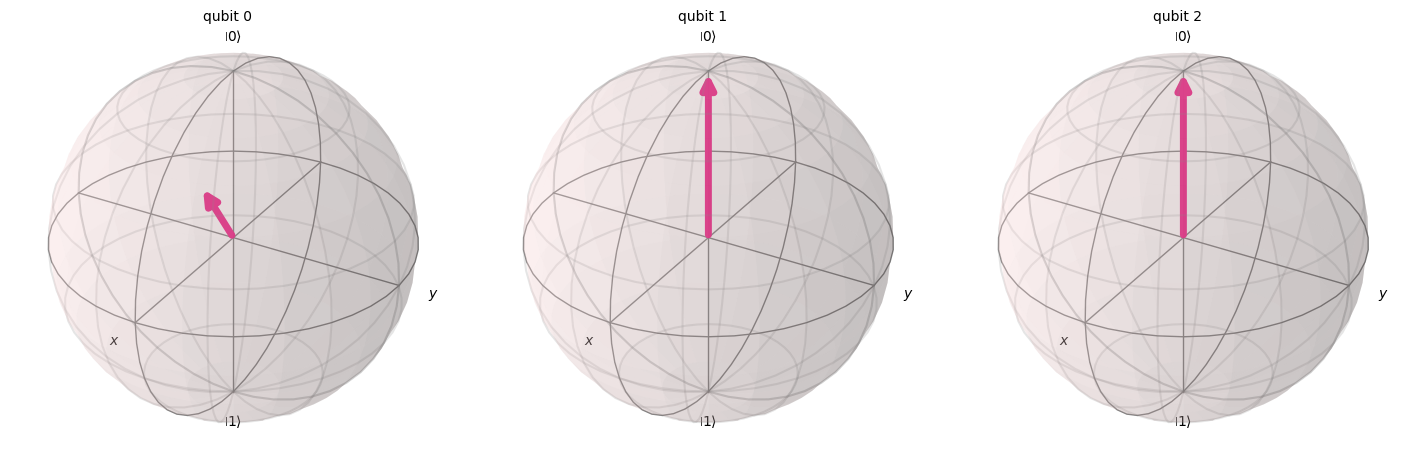

Fidelity between initial and teleported states: 1.000000

Bob’s final qubit (qubit 2) Bloch vector:


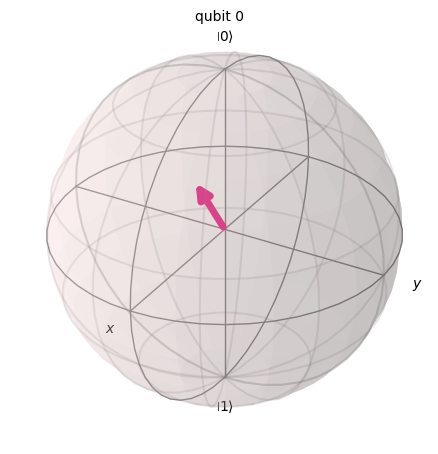

In [2]:
!pip install qiskit
!pip install qiskit_aer
!pip install pylatexenc


# Quantum Teleportation (Coherent version) – Qiskit 2.x compatible
# Works on modern qiskit-aer simulators

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ Build the teleportation circuit
qc = QuantumCircuit(3)

# Prepare arbitrary state |ψ⟩ on qubit 0
theta, phi = 0.8, 0.3
qc.ry(theta, 0)
qc.rz(phi, 0)

# Save initial state for comparison
sv_initial = Statevector.from_instruction(qc)
print("Initial state of qubit 0:")
display(plot_bloch_multivector(sv_initial))

# Create Bell pair between qubits 1 and 2
qc.h(1)
qc.cx(1, 2)

# Bell measurement part (but coherent)
qc.cx(0, 1)
qc.h(0)

# Coherent corrections
qc.cx(1, 2)
qc.cz(0, 2)

# Save final statevector explicitly (Qiskit 2.x requires this)
qc.save_statevector()

# 2️⃣ Simulate
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled).result()

# Retrieve the saved statevector
sv_final = result.data(0)["statevector"]
sv_final = Statevector(sv_final)

# 3️⃣ Compare: initial vs Bob’s (qubit 2) final state
rho_bob = partial_trace(sv_final, [0, 1])
rho_init = partial_trace(sv_initial, [1, 2])

# Extract the dominant pure states (since both should be pure)
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]
init_state = eigvecs_i[:, np.argmax(eigvals_i)]

# Compute fidelity
fidelity = np.abs(np.vdot(init_state, bob_state)) ** 2
print(f"Fidelity between initial and teleported states: {fidelity:.6f}")

# 4️⃣ Visualize Bloch spheres (fixed)
print("\nBob’s final qubit (qubit 2) Bloch vector:")

# Convert rho_bob (DensityMatrix) → pure statevector (dominant eigenvector)
eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
bob_state = eigvecs_b[:, np.argmax(eigvals_b)]  # dominant eigenvector
bob_sv = Statevector(bob_state)

display(plot_bloch_multivector(bob_sv))

In [12]:
#Task 1 - Custom State Teleportation
from math import pi
# Try different custom states
theta = pi/4   # Try pi/4, pi/2, 3*pi/4...
phi   = pi/2   # Try 0, pi/3, pi, etc.

qc = QuantumCircuit(3)

qc.ry(theta, 0)
qc.rz(phi, 0)

# Save initial state
sv_initial = Statevector.from_instruction(qc)

print(f"Chosen State Parameters: θ = {theta:.3f}, φ = {phi:.3f}")
fig = plot_bloch_multivector(sv_initial)
plt.show()

Chosen State Parameters: θ = 0.785, φ = 1.571


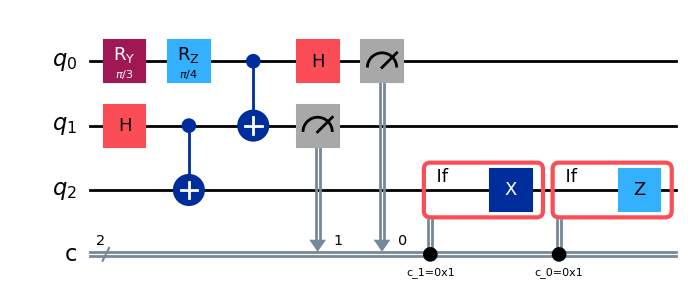

In [16]:
#Task 2 — Add Classical Measurement Version
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit import transpile
from math import pi

# Create registers
q = QuantumRegister(3, 'q')
c = ClassicalRegister(2, 'c')

# Build circuit using registers
qc = QuantumCircuit(q, c)

# 1) Prepare Alice's state (qubit 0)
qc.ry(pi/3, q[0])
qc.rz(pi/4, q[0])

# 2) Create entanglement between q1 and q2
qc.h(q[1])
qc.cx(q[1], q[2])

# 3) Bell measurement operations
qc.cx(q[0], q[1])
qc.h(q[0])

# 4) Measure Alice’s qubits
qc.measure(q[0], c[0])
qc.measure(q[1], c[1])

# 5) Classical conditional corrections (Qiskit 2.x style)
with qc.if_test((c[1], 1)):
    qc.x(q[2])

with qc.if_test((c[0], 1)):
    qc.z(q[2])

# Run simulation
sim = AerSimulator()
compiled = transpile(qc, sim)
result = sim.run(compiled).result()

qc.draw('mpl')

Average Fidelity: 1.0


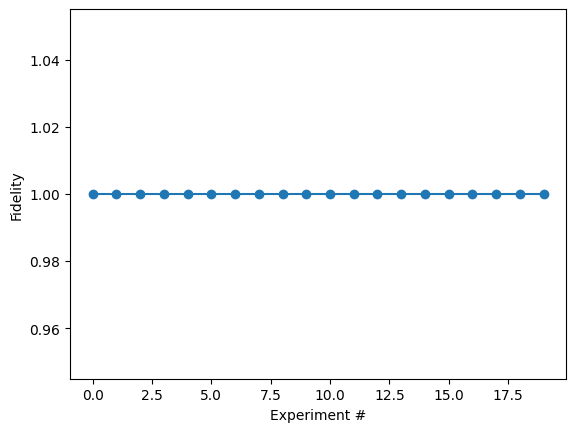

In [17]:
#Task 3 — Fidelity for 10 Random States
import numpy as np
from qiskit.quantum_info import Statevector, partial_trace
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from math import pi

def teleport_fidelity(theta, phi):

    # Build teleportation circuit (coherent version)
    qc = QuantumCircuit(3)
    qc.ry(theta, 0)
    qc.rz(phi, 0)

    sv_initial = Statevector.from_instruction(qc)

    qc.h(1)
    qc.cx(1, 2)
    qc.cx(0, 1)
    qc.h(0)
    qc.cx(1, 2)
    qc.cz(0, 2)

    qc.save_statevector()

    sim = AerSimulator()
    compiled = transpile(qc, sim)
    result = sim.run(compiled).result()

    sv_final = Statevector(result.data(0)["statevector"])

    # Extract Bob’s final qubit and initial prepared qubit
    rho_init = partial_trace(sv_initial, [1, 2])
    rho_bob  = partial_trace(sv_final, [0, 1])

    # Convert DensityMatrix → dominant eigenvector (pure state)
    eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
    init_state = eigvecs_i[:, np.argmax(eigvals_i)]

    eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
    bob_state = eigvecs_b[:, np.argmax(eigvals_b)]

    # Fidelity calculation
    fidelity = np.abs(np.vdot(init_state, bob_state)) ** 2
    return fidelity


# Run for 20 samples
fidelities = []
for _ in range(20):
    theta = np.random.uniform(0, np.pi)
    phi   = np.random.uniform(0, 2*np.pi)
    fidelities.append(teleport_fidelity(theta, phi))

print("Average Fidelity:", np.mean(fidelities))

plt.plot(fidelities, marker='o')
plt.ylabel("Fidelity")
plt.xlabel("Experiment #")
plt.show()


=== Initial State Prepared ===


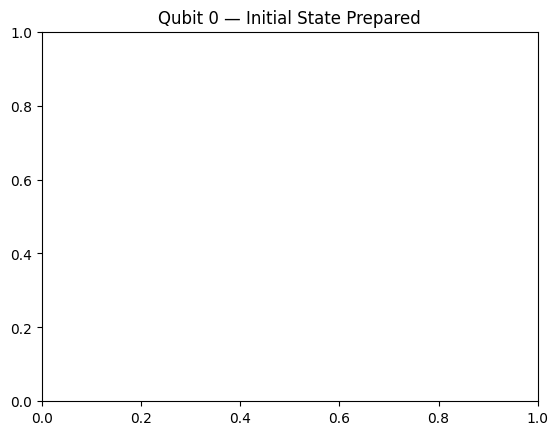

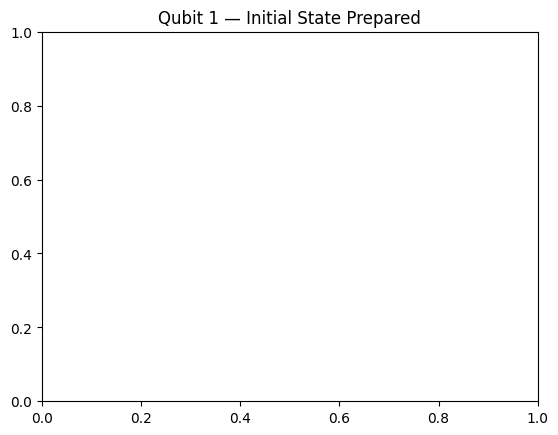

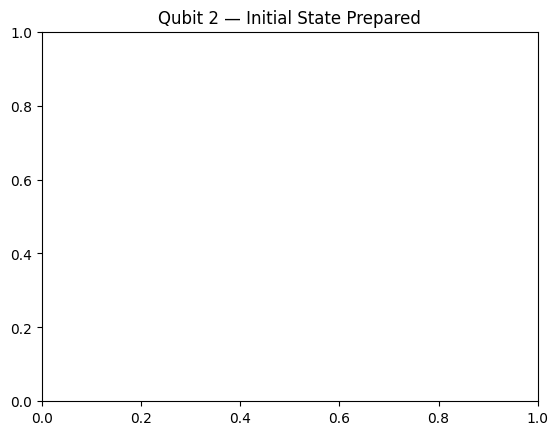


=== Bell Pair Created (q1 ↔ q2 Entangled) ===


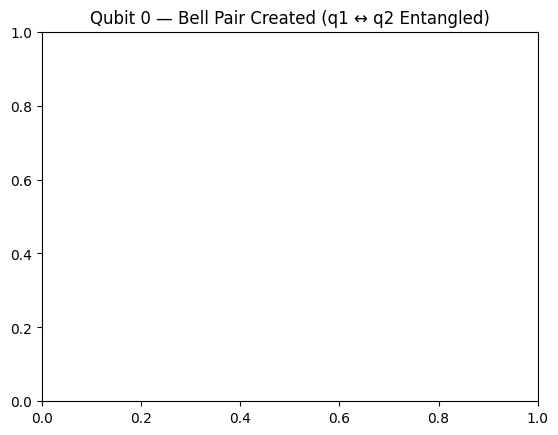

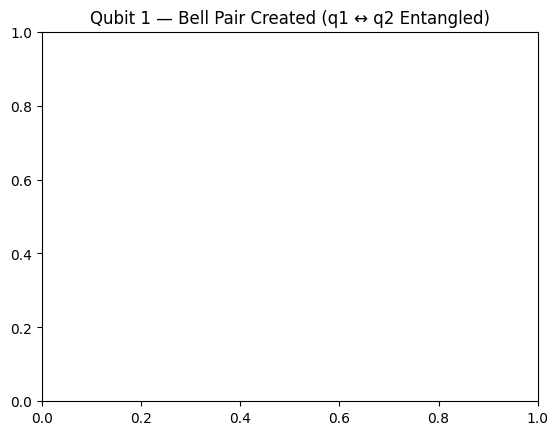

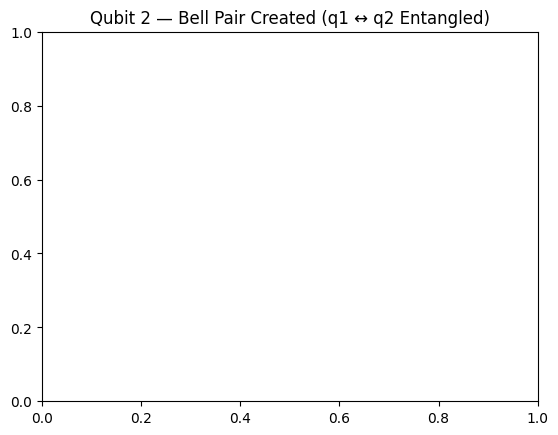


=== Bell Measurement Operations Applied ===


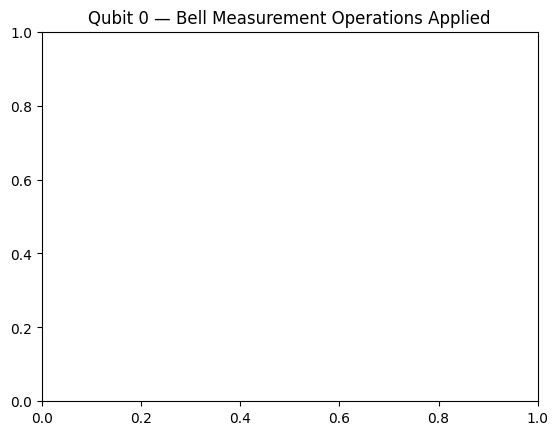

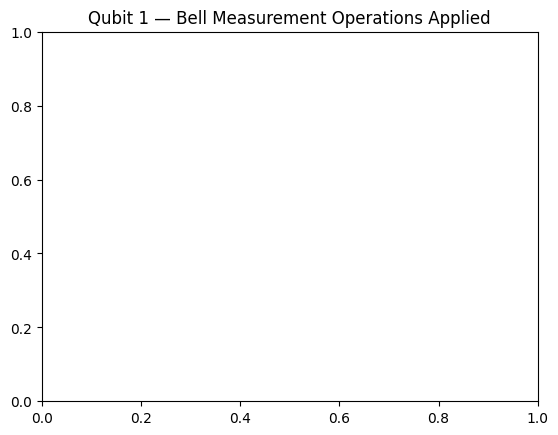

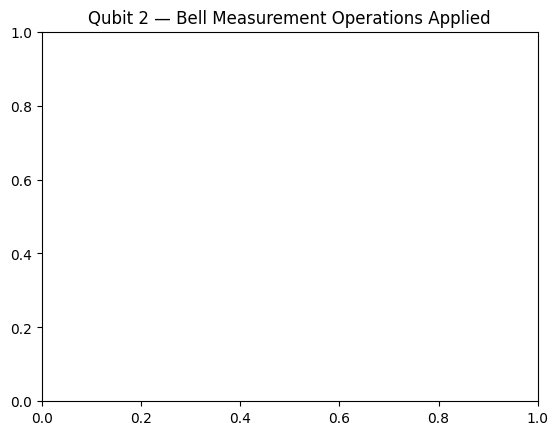


=== Teleportation Complete (State Moved to Qubit 2) ===


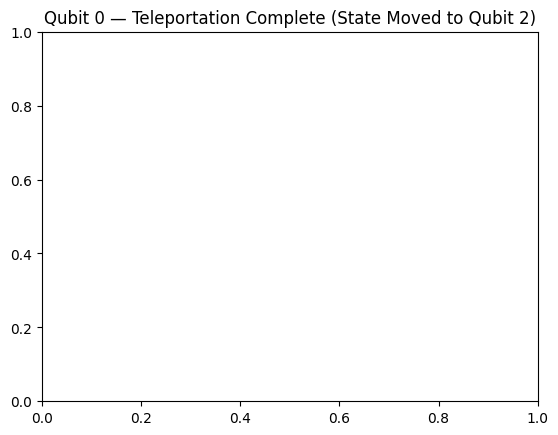

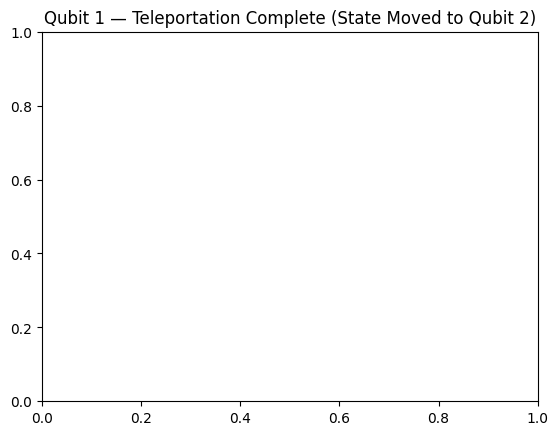

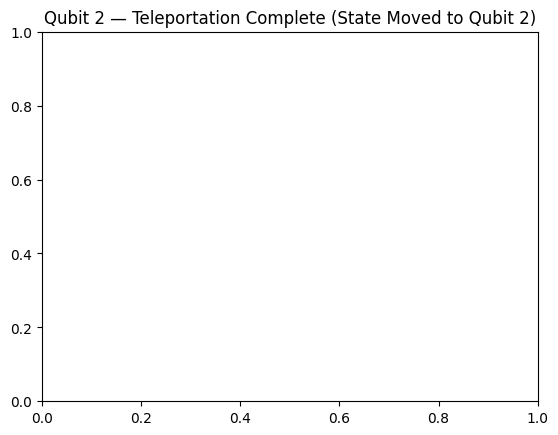


✅ The quantum state originally on qubit 0 is now on qubit 2.



In [20]:
#Task 4 — Step-by-Step Bloch Visualization
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Statevector, partial_trace
from qiskit.visualization import plot_bloch_multivector
from qiskit_aer import AerSimulator
from qiskit import transpile
import matplotlib.pyplot as plt
from math import pi

def show_bloch(qc, title):
    sv = Statevector.from_instruction(qc)
    # Partial trace each qubit to get individual Bloch states
    print(f"\n=== {title} ===")
    for i in range(3):
        rho = partial_trace(sv, [j for j in range(3) if j!=i])
        fig = plot_bloch_multivector(rho)
        plt.title(f"Qubit {i} — {title}")
        plt.show()


# --- Start Teleportation ---
q = QuantumRegister(3, 'q')
qc = QuantumCircuit(q)

# Step 1: Prepare state |ψ⟩ on qubit 0
theta = pi/3
phi   = pi/5
qc.ry(theta, q[0])
qc.rz(phi, q[0])
show_bloch(qc, "Initial State Prepared")

# Step 2: Create Bell pair between qubit 1 and 2
qc.h(q[1])
qc.cx(q[1], q[2])
show_bloch(qc, "Bell Pair Created (q1 ↔ q2 Entangled)")

# Step 3: Apply Bell measurement operations
qc.cx(q[0], q[1])
qc.h(q[0])
show_bloch(qc, "Bell Measurement Operations Applied")

# Step 4: Coherent teleportation corrections
qc.cx(q[1], q[2])
qc.cz(q[0], q[2])
show_bloch(qc, "Teleportation Complete (State Moved to Qubit 2)")

# --- Final verification ---
print("\n✅ The quantum state originally on qubit 0 is now on qubit 2.\n")

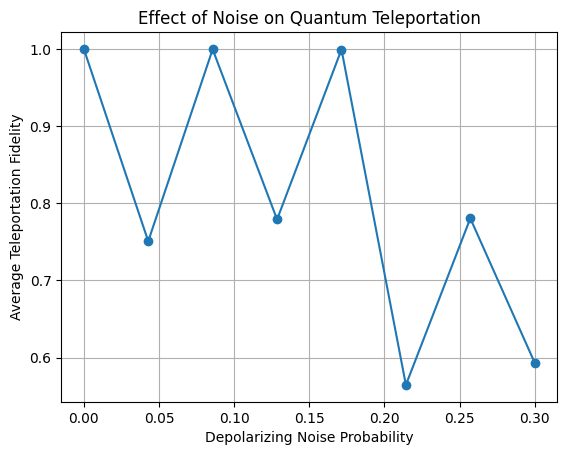


Noise vs Fidelity:
Noise = 0.00 → Fidelity = 1.0000
Noise = 0.04 → Fidelity = 0.7507
Noise = 0.09 → Fidelity = 0.9995
Noise = 0.13 → Fidelity = 0.7790
Noise = 0.17 → Fidelity = 0.9992
Noise = 0.21 → Fidelity = 0.5645
Noise = 0.26 → Fidelity = 0.7804
Noise = 0.30 → Fidelity = 0.5932


In [21]:
#Task 5 — Add Noise
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector, partial_trace
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
import numpy as np
import matplotlib.pyplot as plt
from math import pi

def teleport_fidelity_with_noise(theta, phi, noise_strength):

    # Base teleportation circuit (coherent teleportation)
    qc = QuantumCircuit(3)
    qc.ry(theta, 0)
    qc.rz(phi, 0)

    sv_initial = Statevector.from_instruction(qc)

    qc.h(1)
    qc.cx(1, 2)
    qc.cx(0, 1)
    qc.h(0)
    qc.cx(1, 2)
    qc.cz(0, 2)

    qc.save_statevector()

    # --- Build Noise Model ---
    noise = NoiseModel()
    # Apply depolarizing noise to every CX gate
    noise.add_all_qubit_quantum_error(depolarizing_error(noise_strength, 2), ['cx'])

    sim = AerSimulator(noise_model=noise)
    compiled = transpile(qc, sim)
    result = sim.run(compiled).result()

    sv_final = Statevector(result.data(0)["statevector"])

    # Extract Bob’s final state
    rho_init = partial_trace(sv_initial, [1, 2])
    rho_bob  = partial_trace(sv_final, [0, 1])

    # Convert DensityMatrix → pure statevector via dominant eigenvector
    eigvals_i, eigvecs_i = np.linalg.eigh(rho_init.data)
    init_state = eigvecs_i[:, np.argmax(eigvals_i)]

    eigvals_b, eigvecs_b = np.linalg.eigh(rho_bob.data)
    bob_state = eigvecs_b[:, np.argmax(eigvals_b)]

    # Fidelity calculation
    fidelity = np.abs(np.vdot(init_state, bob_state)) ** 2
    return fidelity

# --- Run teleportation for increasing noise ---
noise_values = np.linspace(0, 0.3, 8)   # Noise from 0 to 0.3
fidelities = []

for noise_strength in noise_values:
    fidelity_samples = []
    for _ in range(8):  # Random states
        theta = np.random.uniform(0, np.pi)
        phi   = np.random.uniform(0, 2*np.pi)
        fidelity_samples.append(
            teleport_fidelity_with_noise(theta, phi, noise_strength)
        )
    fidelities.append(np.mean(fidelity_samples))

# --- Plot Results ---
plt.plot(noise_values, fidelities, marker='o')
plt.xlabel("Depolarizing Noise Probability")
plt.ylabel("Average Teleportation Fidelity")
plt.title("Effect of Noise on Quantum Teleportation")
plt.grid(True)
plt.show()

print("\nNoise vs Fidelity:")
for n,f in zip(noise_values, fidelities):
    print(f"Noise = {n:.2f} → Fidelity = {f:.4f}")